In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
amazon = pd.read_csv('/Users/VuxLe/Desktop/BT4012/project/fake reviews dataset.csv')
yelp = pd.read_excel('/Users/VuxLe/Desktop/BT4012/project/Yelp Labelled Review Dataset with Sentiments and Features.xlsx')

In [5]:
print(amazon.head())
print(amazon['rating'].value_counts())
print(amazon['label'].value_counts())
print(amazon['category'].value_counts())

             category  rating label  \
0  Home_and_Kitchen_5     5.0    CG   
1  Home_and_Kitchen_5     5.0    CG   
2  Home_and_Kitchen_5     5.0    CG   
3  Home_and_Kitchen_5     1.0    CG   
4  Home_and_Kitchen_5     5.0    CG   

                                               text_  
0  Love this!  Well made, sturdy, and very comfor...  
1  love it, a great upgrade from the original.  I...  
2  This pillow saved my back. I love the look and...  
3  Missing information on how to use it, but it i...  
4  Very nice set. Good quality. We have had the s...  
rating
5.0    24559
4.0     7965
3.0     3786
1.0     2155
2.0     1967
Name: count, dtype: int64
label
CG    20216
OR    20216
Name: count, dtype: int64
category
Kindle_Store_5                  4730
Books_5                         4370
Pet_Supplies_5                  4254
Home_and_Kitchen_5              4056
Electronics_5                   3988
Sports_and_Outdoors_5           3946
Tools_and_Home_Improvement_5    3858
Clothing_Shoe

In [6]:
print(yelp.head())

   User_id  Product_id  Rating       Date  \
0      923           0       3 2014-01-30   
1      924           0       3 2011-05-05   
2      925           0       4 2011-12-30   
3      926           0       4 2012-10-04   
4      927           0       4 2014-02-06   

                                              Review  Spam(1) and Not Spam(0)  \
0  The food at snack is a selection of popular Gr...                        1   
1  This little place in Soho is wonderful. I had ...                        1   
2  ordered lunch for 15 from Snack last Friday. Ã...                        1   
3  This is a beautiful quaint little restaurant o...                        1   
4  Snack is great place for a Ã‚Â casual sit down...                        1   

  Sentiment                                           Features  
0  Positive  ['appetizer tray', 'greek salad', 'main courses']  
1  Positive  ['little place', 'soho', 'lamb sandwich', 'soh...  
2  Positive            ['snack', 'regular compa

In [65]:
print(yelp['Spam(1) and Not Spam(0)'].value_counts())

Spam(1) and Not Spam(0)
0    319077
1     36133
Name: count, dtype: int64


In [8]:
# rename label column
yelp.rename(columns={'Spam(1) and Not Spam(0)': 'label'}, inplace=True)
print(yelp['label'].value_counts())

label
0    319077
1     36133
Name: count, dtype: int64


In [34]:
# Drop duplicates in amazon dataset
amazon = amazon.drop_duplicates()

In [35]:
# Change label values in amazon dataset
amazon['label'] = amazon['label'].replace('CG', 1)
amazon['label'] = amazon['label'].replace('OR', 0)

/var/folders/53/nj5flq8j0vvdtf3hkb5gb_7h0000gp/T/ipykernel_34481/983898789.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  amazon['label'] = amazon['label'].replace('OR', 0)


**Feature engineering for Amazon dataset**

In [62]:
#inspect some random 5 star reviews and their corresponding text_ in amazon dataset
five_star_samples = amazon[amazon['rating'] == 5].sample(n=5)

for idx, row in five_star_samples.iterrows():
    print(f"\n{'='*80}")
    print(f"Rating: {row['rating']}")
    print(f"Review:\n{row['text_']}")
    print(f"{'='*80}")



Rating: 5.0
Review:
It's basic 16 gauge speaker wire. Not super flexible, but not hard to work with, has a durable feel, and strips cleanly even with cheap stripers.

Rating: 5.0
Review:
Use it to rinse the dog's teeth.  Not too much work for a small dog.Great product. Great price.

Rating: 5.0
Review:
I picked this up for my 9 year old son. He loves it! He loves to throw it around and

Rating: 5.0
Review:
Switching from IOS to Android (iPod) and using the internet to access my music through the app is so simple that it's a must have for the beginning of the home theater experience.

The app is really good, it's a very simple and easy to use interface that is easy to navigate and has a great range of options.

I'd definitely recommend this product.I just bought a new laptop and I am extremely happy with it. It's very easy to use and very easy to use. The only thing I wish I could add is that the design of the keyboard is very nice. It is really difficult to find a keyboard with such a

In [63]:
#inspect some random 1 star reviews and their corresponding text_ in amazon dataset
five_star_samples = amazon[amazon['rating'] == 1].sample(n=5)

for idx, row in five_star_samples.iterrows():
    print(f"\n{'='*80}")
    print(f"Rating: {row['rating']}")
    print(f"Review:\n{row['text_']}")
    print(row['label'])
    print(f"{'='*80}")


Rating: 1.0
Review:
When a sump pump goes bellyup it usually happens when you need it most. Which means you can't wait for shipping or shop price, you head to the hardware store and pay top buck. After numerous Wayne pump float switches died (usually just after the warranty expires)I saw this one with the Switch Genius technology. At 3/4 HP it was more pump than I needed and it was the most expensive sump pump I ever bought. But I figured if the switch was more reliable than float switches the piece of mind would be worth the money.

I noticed the switch cycles the pump on early and shuts off only after sucking air for 10 - 15 seconds. After some severe storms a few weeks later I came home from work and could smell something hot. The pump wasn't turning off and was hotter than blazes! After following the manual and cleaning off the sensor it still wouldn't shut off. After unplugging the pump for half an hour or so it appeared to work normally again. Every time there's a storm I have t

Review text preprocessing

In [36]:
def preprocess_text(text):
    # Handle NaN values
    if pd.isna(text):
        return ''
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization with POS tagging for better accuracy
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]  # Lemmatize as verbs
    tokens = [lemmatizer.lemmatize(token, pos='n') for token in tokens]  # Lemmatize as nouns
    
    # Remove short words (optional)
    tokens = [token for token in tokens if len(token) > 2]
    
    return ' '.join(tokens)

# Apply preprocessing on amazon dataset
amazon['preprocessed_text'] = amazon['text_'].apply(preprocess_text)

# To check the preprocessing results:
def show_preprocessing_example():
    # Get a random sample
    sample = amazon.sample(n=1).iloc[0]
    print("Original text:")
    print(sample['text_'])
    print("\nPreprocessed text:")
    print(sample['preprocessed_text'])
    
show_preprocessing_example()

Original text:
If you are interested in learning what happens at sea when boredom, monotony, ennui  and endless accounts of filler material taken from every one of the good, action packed adventures that began this series then this is the book for you. I happen to like learning what a day may have looked like at sea in that era but not to the extent that it is all that we learn about over all the pages except the last thirty when the action begins but is broken with an abrupt ending. Of course the action resumes where it left off at the beginning of the next book. In what is rapidly becoming a dissatisfying series, this is the supreme example of dissatisfaction up to this point in my opinion. As usual, I cant fault the writing but the point of this story seems to have been to sell one more book no matter the consequences of not providing an entertaining story. When I first read this series I thought every one of them was a masterpiece of naval historical work. Now that Ive been hooked 

Sentiment analysis on amazon data's reviews


Distribution for sentiment_vader:
positive: 34190 reviews (84.59%)
neutral: 1888 reviews (4.67%)
negative: 4342 reviews (10.74%)

Sentiment vs Ratings Analysis:

Percentage of sentiments for each rating:
rating                 1.0        2.0        3.0        4.0        5.0
sentiment_vader                                                       
negative         38.375870  28.215557  17.828843   9.064658   6.367377
neutral           8.445476   7.676665   5.731643   4.005022   4.151220
positive         53.178654  64.107778  76.439514  86.930320  89.481403

Sample Reviews with Sentiments:

Text: This is a great little tool. The only problem is that it takes a little getting used to....
Rating: 5.0
VADER Sentiment: positive

Text: Review do-over.  Continued to ask for disc every time. It's obvious  that this product should be sold with a disc. Not solo. Never worked again question if the adaptor had any thing to do with it work...
Rating: 1.0
VADER Sentiment: neutral

Text: he's SUPER soft

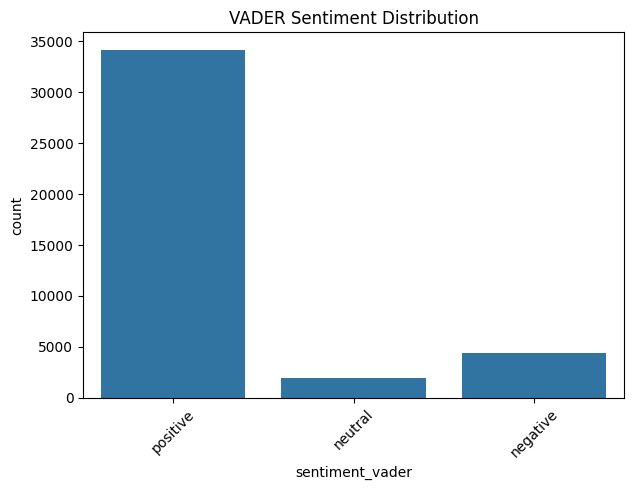

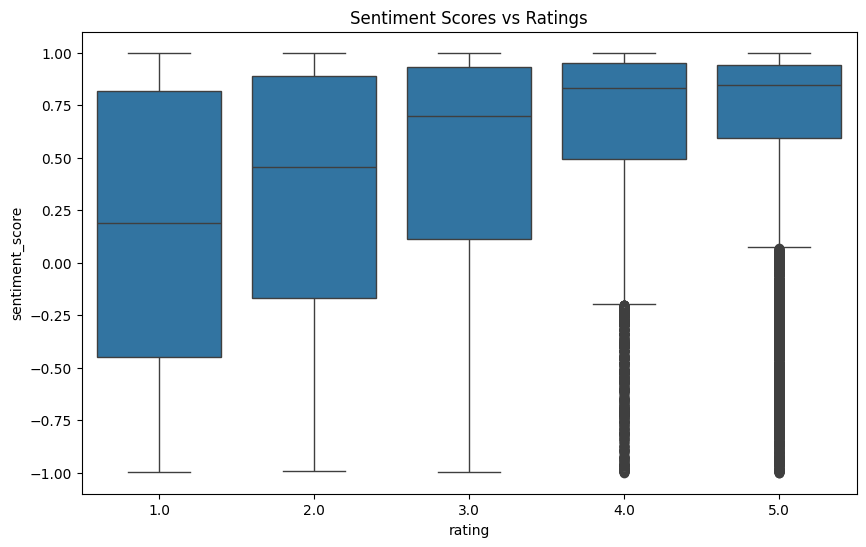


High Confidence Examples for Each Sentiment:

POSITIVE Reviews (High Confidence):

Text: I was blown away by this movie, and the acting was superb. There were a few moments in the movie that I missed. The script and directing were top notch. The acting was flawless. The acting was excelle...
Confidence: 1.00

Text: Ok, I have to admit that I didn't finish this book. I just didn't want to finish it. The book is a bit long, but it was great. The story was well told and the characters were strong. I would recommend...
Confidence: 1.00

NEGATIVE Reviews (High Confidence):

Text: Theodore Boone: The Accused by John Grisham, The Art of Murder, The Murder of the Innocent, The Murder of the Guilty, The Murder of the Innocent, The Murder of the Guilty, The Murder of the Guilty, Th...
Confidence: 1.00

Text: Matheson said, ". when I saw the movie, I just wasn't sure how to read it. "

The movie had a lot of "playful" dialogue, but it was not that funny. It was a good movie, but it was not very 

In [37]:
def analyze_sentiment_vader(text):
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(str(text))
    compound = scores['compound']
    
    if compound > 0.05:
        return 'positive'
    elif compound < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis method
amazon['sentiment_vader'] = amazon['text_'].apply(analyze_sentiment_vader)

# Analyze distribution of sentiments
def print_sentiment_distribution(sentiment_column):
    distribution = amazon[sentiment_column].value_counts()
    percentages = amazon[sentiment_column].value_counts(normalize=True) * 100
    
    print(f"\nDistribution for {sentiment_column}:")
    for category in ['positive', 'neutral', 'negative']:
        count = distribution.get(category, 0)
        percentage = percentages.get(category, 0)
        print(f"{category}: {count} reviews ({percentage:.2f}%)")

print_sentiment_distribution('sentiment_vader')

# Compare with ratings
def analyze_sentiment_vs_ratings():
    print("\nSentiment vs Ratings Analysis:")
    sentiment_rating_comparison = pd.crosstab(amazon['sentiment_vader'], 
                                            amazon['rating'], 
                                            normalize='columns') * 100
    print("\nPercentage of sentiments for each rating:")
    print(sentiment_rating_comparison)

analyze_sentiment_vs_ratings()

# Sample reviews with their sentiments
def show_sample_reviews():
    print("\nSample Reviews with Sentiments:")
    samples = amazon.sample(5)
    for _, row in samples.iterrows():
        print("\n" + "="*80)
        print(f"Text: {row['text_'][:200]}...")
        print(f"Rating: {row['rating']}")
        print(f"VADER Sentiment: {row['sentiment_vader']}")

show_sample_reviews()

def plot_sentiment_distribution():
    plt.figure(figsize=(12, 5))
    
    # VADER sentiment distribution
    plt.subplot(1, 2, 1)
    sns.countplot(data=amazon, x='sentiment_vader')
    plt.title('VADER Sentiment Distribution')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_sentiment_distribution()

# Create a sentiment score column (for more granular analysis)
def get_sentiment_score(text):
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(str(text))['compound']

amazon['sentiment_score'] = amazon['text_'].apply(get_sentiment_score)

# Compare sentiment scores with ratings
def plot_sentiment_vs_ratings():
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=amazon, x='rating', y='sentiment_score')
    plt.title('Sentiment Scores vs Ratings')
    plt.show()

plot_sentiment_vs_ratings()

# Add confidence levels to sentiments
def get_sentiment_with_confidence(text):
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(str(text))
    compound = scores['compound']
    
    if compound > 0.05:
        confidence = min(abs(compound - 0.05) / 0.95, 1.0)
        return 'positive', confidence
    elif compound < -0.05:
        confidence = min(abs(compound + 0.05) / 0.95, 1.0)
        return 'negative', confidence
    else:
        confidence = 1 - (abs(compound) / 0.05)
        return 'neutral', confidence

# Apply sentiment analysis with confidence
amazon[['sentiment', 'confidence']] = pd.DataFrame(
    amazon['text_'].apply(get_sentiment_with_confidence).tolist(),
    index=amazon.index
)

# Show high-confidence examples for each category
def show_high_confidence_examples():
    print("\nHigh Confidence Examples for Each Sentiment:")
    for sentiment in ['positive', 'negative', 'neutral']:
        print(f"\n{sentiment.upper()} Reviews (High Confidence):")
        samples = amazon[amazon['sentiment'] == sentiment].nlargest(2, 'confidence')
        for _, row in samples.iterrows():
            print(f"\nText: {row['text_'][:200]}...")
            print(f"Confidence: {row['confidence']:.2f}")

show_high_confidence_examples()

In [38]:
amazon.head()

,category,rating,label,text_,preprocessed_text,sentiment_vader,sentiment_score,sentiment,confidence
0,Home_and_Kitchen_5,5.0,1,"Love this! Well made, sturdy, and very comfor...",love well make sturdy comfortable love itvery ...,positive,0.9593,positive,0.957158
1,Home_and_Kitchen_5,5.0,1,"love it, a great upgrade from the original. I...",love great upgrade original ive mine couple year,positive,0.8910,positive,0.885263
2,Home_and_Kitchen_5,5.0,1,This pillow saved my back. I love the look and...,pillow save back love look feel pillow,positive,0.7906,positive,0.779579
3,Home_and_Kitchen_5,1.0,1,"Missing information on how to use it, but it i...",miss information use great product price,positive,0.7463,positive,0.732947
4,Home_and_Kitchen_5,5.0,1,Very nice set. Good quality. We have had the s...,nice set good quality set two month,positive,0.7397,positive,0.726000


In [39]:
amazon.to_csv('/Users/VuxLe/Desktop/BT4012/project/amazon_preprocessed.csv', index=False)

In [61]:
yelp.to_csv('/Users/VuxLe/Desktop/BT4012/project/yelp_preprocessed.csv', index=False)

Apply TF-IDF

In [57]:
tfidf = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X_tfidf = tfidf.fit_transform(amazon['preprocessed_text'])

# Convert to DataFrame for easier handling
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

Split training and test set

In [58]:
# Combine features
features = pd.concat([tfidf_df.reset_index(drop=True), 
                      amazon['rating'].reset_index(drop=True), 
                      pd.get_dummies(amazon['sentiment']).reset_index(drop=True)], axis=1)

X = features
y = amazon['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model testing

In [59]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

/Users/VuxLe/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Results:")
    print(classification_report(y_true, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, lr_pred, "Logistic Regression")


Random Forest Results:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      4029
           1       0.83      0.84      0.84      4055

    accuracy                           0.84      8084
   macro avg       0.84      0.84      0.84      8084
weighted avg       0.84      0.84      0.84      8084


Confusion Matrix:
[[3345  684]
 [ 647 3408]]

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      4029
           1       0.84      0.85      0.85      4055

    accuracy                           0.84      8084
   macro avg       0.84      0.84      0.84      8084
weighted avg       0.84      0.84      0.84      8084


Confusion Matrix:
[[3385  644]
 [ 613 3442]]


**Feature Engineering for Yelp dataset**

In [9]:
#Apply preprocessing on yelp dataset
yelp['preprocessed_text'] = yelp['Review'].apply(preprocess_text)

# To check the preprocessing results:
def show_preprocessing_example():
    # Get a random sample
    sample = yelp.sample(n=1).iloc[0]
    print("Original text:")
    print(sample['Review'])
    print("\nPreprocessed text:")
    print(sample['preprocessed_text'])

show_preprocessing_example()

Original text:
Okay, this place is worth the wait - at least once. My friend and I strolled over here lazily on a Sunday at 1:30pm, expecting a long wait. Boy, we got one! We waited about an hour and twenty minutes for a table for two. The food was everything I hoped it would be and more: homemade sour pickles and a fried chicken-egg-bacon-cheese biscuit with cheesy grits for me, and the chicken and pancakes with an extra chocolate chip banana biscuit for my friend. Everything tasted extremely fresh and delicious AND was delivered to our table in a timely manner, despite the fact that the restaurant was insanely busy. Dare I say this place could turn me into a pickle-obsessed freak? I've never been a huge fan of pickles but they were amazing here and I gobbled them up like they were going out of style. I'll be back at some point but I don't think I'd want to wait nearly 1.5 hours every time I want brunch. Come here before the Sunday rush - Ã‚Â but definitely make sure you get over to J

In [16]:
samples = yelp.sample(n=5)

for idx, row in samples.iterrows():
    print(f"\n{'='*80}")
    print(f"Original text: {row['Review']}")
    print(f"Preprocessed text: \n{row['preprocessed_text']}")
    print(f"{'='*80}")


Original text: This huge food emporium is impressive in sheer size and thoroughness of products available...there's anything you might think of when you think of Italy, in both prepared / ready to eat and grocery, prepared or raw/ready to prepare. I think this place is a little over-the-top though due to shameless shilling of the sponsor country, and I don't find it easy to navigate during peak rush hours. Ã‚Â The food is delish though--so far I've eaten at the fish counter, the roasted meats counter, the coffee bar, and the chocolate/confections bar. Ã‚Â Everything is well-made and tastes great; BUT this is a place for expense accounts only (does anyone even have one of these anymore??). Ã‚Â Very pricey food--lunch will cost $20-$30 at least, and that's if you order from the counter and eat standing up.
Preprocessed text: 
huge food emporium impressive sheer size thoroughness product availabletheres anything might think think italy prepare ready eat grocery prepare rawready prepare t

In [19]:
# Inspect some 5 stars rating and their corresponding preprocessed text in yelp dataset
five_star_samples = yelp[yelp['Rating'] == 1].sample(n=5)

for idx, row in five_star_samples.iterrows():
    print(f"\n{'='*80}")
    print(f"Rating: {row['Rating']}")
    print(f"Sentiment: {row['Sentiment']}")
    print(f"Review:\n{row['Review']}")
    print(f"Preprocessed text:\n{row['preprocessed_text']}")
    print(f"{'='*80}")


Rating: 1
Sentiment: Negative
Review:
 Location This is an expensive hotel set to 4 stars BUT the hotel and its services does not justify the price Although it was indicated that its located in the Marais area they failed to mention it was in the outskirts of it Services and Staff The room service didn t apply the basic needs such as toilet paper The breakfast was very poor The buffet offered low range of products and their amount was relatively small The manager of the hotel claimed that we were supposed to ask one of the employees to add more from fridge since it s a small hotel and they can t put it all outside poor and unconvincing excuse in my opinion and generally speaking it felt like they were cheap about everything they offered Interior Design The hotel interior s was depressing dark and unfriendly Rank In one word DISAPPOINTING I would highly recommended not to go there 4 
Preprocessed text:
location expensive hotel set star hotel service justify price although indicate loca